# Linear programming zoning

In [43]:
import geopandas as gpd
from blocksnet.preprocessing.land_use_optimizer import LandUseOptimizer

blocks = gpd.read_parquet('data/blocks.parquet')[['geometry']].reset_index(drop=True)
# blocks.geometry = blocks.buffer(-0.5)
# blocks = blocks.explode().reset_index(drop=True)
# blocks = LandUseOptimizer(blocks).blocks
blocks['area'] = blocks.area
blocks['share'] = blocks.area / blocks.area.sum()
blocks['land_use'] = None

In [44]:
import networkx as nx

adjacency_graph = LandUseOptimizer._get_adjacency_graph(blocks)

## Rules

In [47]:
A = nx.to_pandas_adjacency(adjacency_graph)
for i in blocks.index:
  if not i in A.columns:
    A[i] = 0
  if not i in A.index:
    A.loc[i] = 0
n = len(A)
A.head()

,0,3,307,5379,7526,7524,1058,2,1382,419,...,15895,15902,15935,16001,16003,16005,16012,16147,16149,16319
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
307,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5379,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7526,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
from blocksnet.preprocessing.land_use_optimizer import RULES_GRAPH
from blocksnet.models import LandUse

lu_list = list(LandUse)

B = nx.to_pandas_adjacency(RULES_GRAPH).rename(columns=lu_list.index, index=lu_list.index)
m = len(B)
B

,0,1,2,4,6,3,5
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,1.0,1.0,1.0,1.0
6,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,1.0,1.0,1.0,1.0,1.0
5,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [49]:
from blocksnet.utils.helpers import get_polygon_aspect_ratio

ASPECT_RATIO_RANGES = {
    LandUse.RESIDENTIAL: (1, 3),
    LandUse.BUSINESS: (1, 4),
    LandUse.RECREATION: (1, 7),
    LandUse.SPECIAL: (1, 6),
    LandUse.INDUSTRIAL: (1, 5),
    LandUse.AGRICULTURE: (1, 4),
    LandUse.TRANSPORT: (1, 7),
}

blocks['aspect_ratio'] = blocks.geometry.apply(get_polygon_aspect_ratio)
blocks.head()

,geometry,area,share,land_use,aspect_ratio
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",8.044667e+05,0.000591,None,2.194869
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",2.317313e+04,0.000017,None,15.785382
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",3.630058e+05,0.000267,None,1.107639
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",1.964145e+05,0.000144,None,2.632711
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",1.781752e+06,0.001310,None,1.864688


In [50]:
AREA_RANGES = {
    LandUse.RESIDENTIAL: (2_000, 100_000),
    LandUse.BUSINESS: (50_000, 150_000),
    LandUse.RECREATION: (10_000, 1_000_000),
    LandUse.SPECIAL: (50_000, 500_000),
    LandUse.INDUSTRIAL: (10_000, 800_000),
    LandUse.AGRICULTURE: (300_000, 1_000_000),
    LandUse.TRANSPORT: (50_000, 500_000),
}

## Objective

In [51]:
lu_shares = {
  LandUse.RESIDENTIAL: 0.2,
  LandUse.BUSINESS: 0.2,
  LandUse.RECREATION: 0.2,
  LandUse.SPECIAL: 0.1,
  LandUse.INDUSTRIAL: 0.1,
  LandUse.AGRICULTURE: 0.1,
  LandUse.TRANSPORT: 0.1
}

sum(lu_shares.values())

1.0

In [54]:
import pulp

def solve(delta = 0.1):
    prob = pulp.LpProblem("Test", pulp.LpMinimize)

    # Переменные C[k][i] = 1, если кварталу i присвоена зона k
    C = [[pulp.LpVariable(f"C_{k}_{i}", cat="Binary") for i in range(n)] for k in range(m)]

    # Ограничение: каждому кварталу присваивается максимум одна зона
    for i in range(n):
        prob += pulp.lpSum([C[k][i] for k in range(m)]) <= 1

    # Ограничение: некоторым кварталам нельзя ставить некоторые зоны
    for i in range(n):
        block_aspect_ratio = blocks.loc[i, 'aspect_ratio']
        block_area = blocks.loc[i, 'area']
        for k in range(m):
            lu_aspect_ratio = ASPECT_RATIO_RANGES[lu_list[k]][1]
            lu_min_area, lu_max_area = AREA_RANGES[lu_list[k]]
            if block_aspect_ratio > lu_aspect_ratio or block_area < lu_min_area or block_area > lu_max_area :
                prob += C[k][i] == 0

    for k in range(m):
        # Фактическая доля кварталов, отведенных под зону k
        fact_k = pulp.lpSum([C[k][i] * blocks.loc[i, 'share'] for i in range(n)])
        
        # Желательная доля кварталов для зоны k
        desired_k = lu_shares[lu_list[k]]
        
        # Ограничения на отклонения
        prob += fact_k <= (desired_k + delta)
        prob += fact_k >= (desired_k - delta)

    # Ограничения на правильность соседства
    for i in range(n):
        for j in range(i+1, n):
            if A[i][j] == 1:  # Если кварталы i и j соседние
                for k in range(m):
                    for l in range(m):
                        if B[k][l] == 0:
                            # Ограничение: запрещенные зоны не могут соседствовать
                            prob += C[k][i] + C[l][j] <= 1

    # Целевая функция - минимизация расстояний между кварталами с меткой 0 и остальными
    # objective = pulp.lpSum(
    #     blocks.loc[i,'share'] * distances[i, j] * C[0][i] 
    #     for i in range(n) 
    #     for j in range(n) if i != j
    # )

    # Целевая функция - минимизация одинаковых зон у соседних кварталов
    objective = pulp.lpSum(
        C[k][i] + C[k][j] 
        for i in range(n) 
        for j in range(i + 1, n) 
        if A[i][j] == 1  # если кварталы i и j соседние
        for k in range(m)
    )

    # Добавляем целевую функцию в задачу
    prob += objective

    # Решаем задачу
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # Выводим результат
    res = {}
    for i in range(n):
        for k in range(m):
            if pulp.value(C[k][i]) == 1:
                res[i] = k
    return res, prob.status

In [56]:
delta = 0.5
res, status = solve(delta)
print(status)

1


In [40]:
blocks['land_use'] = blocks.apply(lambda s : lu_list[res[s.name]], axis=1)

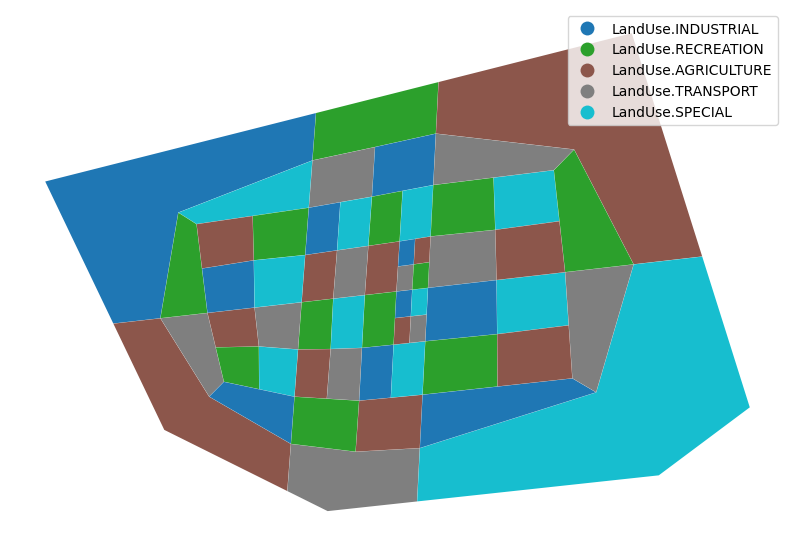

In [41]:
blocks.plot(column='land_use', legend=True, figsize=(10,10)).set_axis_off()